**Missing values**

In [17]:
# Config & load splits (prefers your balanced train)

import pandas as pd, numpy as np, pathlib, os, re, matplotlib.pyplot as plt
SAVE_OUT = pathlib.Path("results/outputs"); SAVE_OUT.mkdir(parents=True, exist_ok=True)
SAVE_VIZ = pathlib.Path("results/eda_visualizations"); SAVE_VIZ.mkdir(parents=True, exist_ok=True)

# set/confirm target
TARGET = "Default"  # change if needed

# load splits (balanced train if available)
p_train_bal = SAVE_OUT/"train_balanced_over.csv"   # or ..._under.csv if you used under
p_train     = SAVE_OUT/"train_split.csv"
p_val       = SAVE_OUT/"val_split.csv"
p_test      = SAVE_OUT/"test_split.csv"

if p_train_bal.exists():
    train = pd.read_csv(p_train_bal)
    print("Loaded:", p_train_bal)
else:
    train = pd.read_csv(p_train)
    print("Loaded:", p_train)

val  = pd.read_csv(p_val);  print("Loaded:", p_val)
test = pd.read_csv(p_test); print("Loaded:", p_test)

assert TARGET in train.columns, "TARGET not found in train."


Loaded: results/outputs/train_balanced_over.csv
Loaded: results/outputs/val_split.csv
Loaded: results/outputs/test_split.csv


[train] shape=(862, 7)  columns with any nulls: 0


,null_frac,null_pct
CustomerID,0.0,0.0
Age,0.0,0.0
AnnualIncome,0.0,0.0
LoanAmount,0.0,0.0
CreditScore,0.0,0.0
LoanTerm,0.0,0.0
ExistingDebt,0.0,0.0


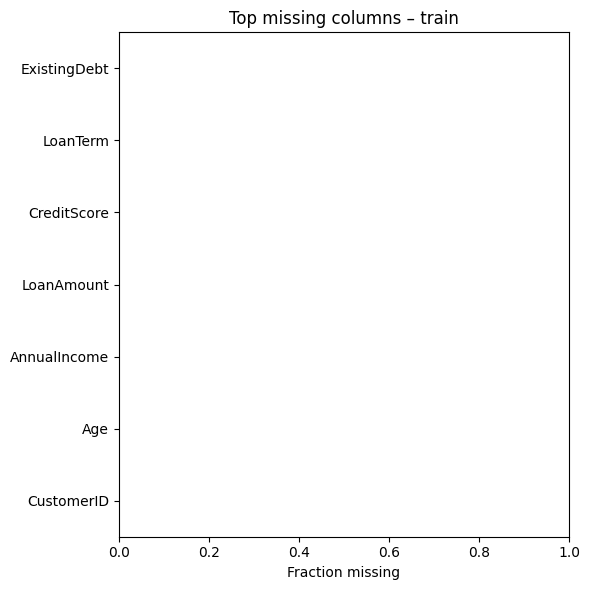

[val] shape=(150, 7)  columns with any nulls: 0


,null_frac,null_pct
CustomerID,0.0,0.0
Age,0.0,0.0
AnnualIncome,0.0,0.0
LoanAmount,0.0,0.0
CreditScore,0.0,0.0
LoanTerm,0.0,0.0
ExistingDebt,0.0,0.0


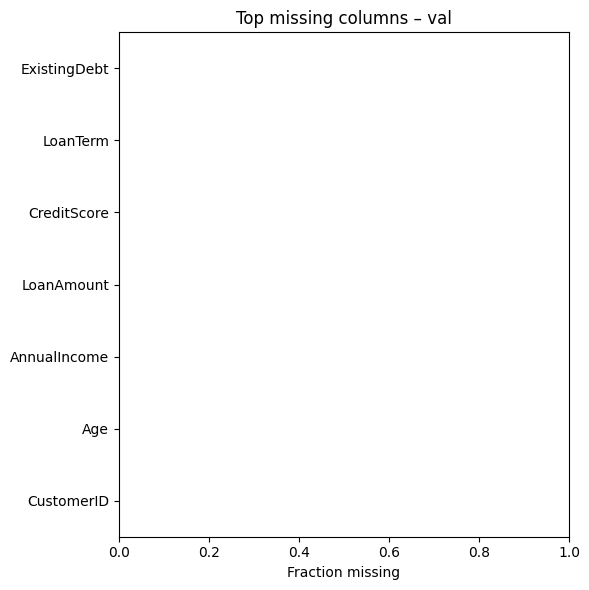

[test] shape=(150, 7)  columns with any nulls: 0


,null_frac,null_pct
CustomerID,0.0,0.0
Age,0.0,0.0
AnnualIncome,0.0,0.0
LoanAmount,0.0,0.0
CreditScore,0.0,0.0
LoanTerm,0.0,0.0
ExistingDebt,0.0,0.0


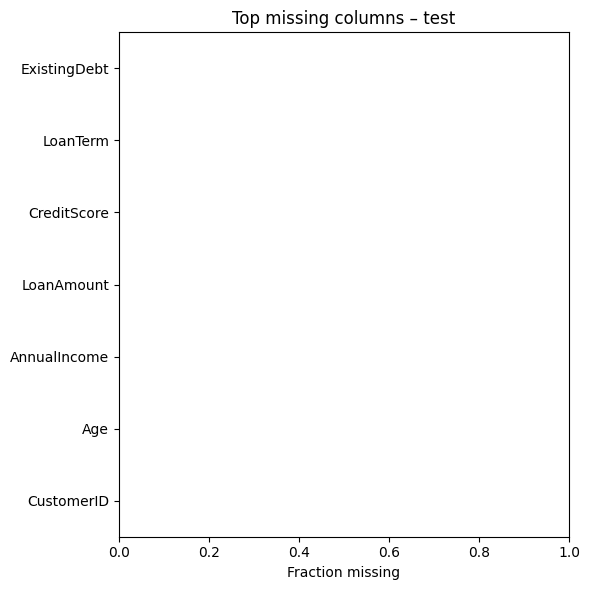

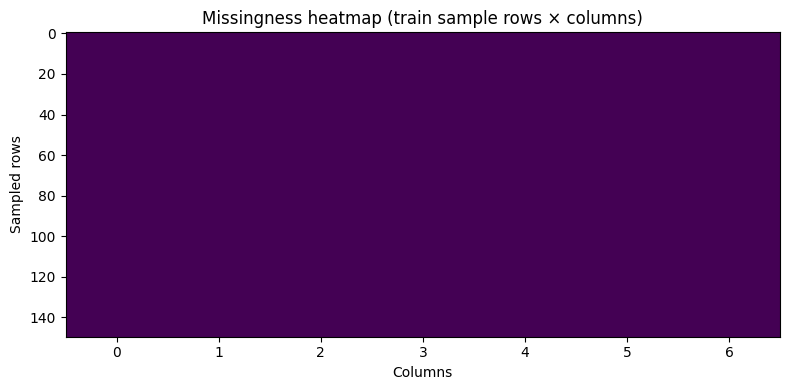

In [18]:
#Missingness audit (top columns, plots, CSV report)

def missing_summary(df, name):
    ms = df.isna().mean().sort_values(ascending=False).to_frame("null_frac")
    ms["null_pct"] = (100*ms["null_frac"]).round(2)
    ms.to_csv(SAVE_OUT/f"missing_summary_{name}.csv")
    print(f"[{name}] shape={df.shape}  columns with any nulls: {(ms['null_frac']>0).sum()}")
    display(ms.head(20))
    # bar plot for top-20
    top = ms.head(20)["null_frac"]
    ax = top.plot(kind="barh", figsize=(6,6))
    ax.set_xlim(0,1); ax.set_xlabel("Fraction missing"); ax.set_title(f"Top missing columns – {name}")
    plt.tight_layout(); plt.savefig(SAVE_VIZ/f"missing_top20_{name}.png", dpi=160); plt.show()
    return ms

ms_train = missing_summary(train.drop(columns=[TARGET]), "train")
ms_val   = missing_summary(val.drop(columns=[TARGET]),   "val")
ms_test  = missing_summary(test.drop(columns=[TARGET]),  "test")

# simple heatmap on a sample of rows (helps for viva screenshots)
sample = train.drop(columns=[TARGET]).sample(min(150, len(train)), random_state=7)
plt.figure(figsize=(8,4))
plt.imshow(sample.isna(), aspect="auto", interpolation="nearest")
plt.title("Missingness heatmap (train sample rows × columns)")
plt.xlabel("Columns"); plt.ylabel("Sampled rows")
plt.tight_layout(); plt.savefig(SAVE_VIZ/"missing_heatmap_train.png", dpi=160); plt.show()


In [19]:
# Add _was_missing flags (top K problematic columns)

TOP_K = 10
ms_sorted = ms_train["null_frac"].loc[ms_train["null_frac"].between(0.01, 0.60)]
flag_cols = ms_sorted.head(TOP_K).index.tolist()
print("Columns to flag with _was_missing:", flag_cols)

def add_missing_flags(df, cols):
    df2 = df.copy()
    for c in cols:
        df2[f"{c}_was_missing"] = df2[c].isna().astype(int)
    return df2

train_f = add_missing_flags(train, flag_cols)
val_f   = add_missing_flags(val,   flag_cols)
test_f  = add_missing_flags(test,  flag_cols)


Columns to flag with _was_missing: []


In [20]:
#Impute (fit on TRAIN only → apply to all)

from sklearn.impute import SimpleImputer
import joblib, numpy as np

# split features/target
X_train = train_f.drop(columns=[TARGET]); y_train = train_f[TARGET]
X_val   = val_f.drop(columns=[TARGET]);   y_val   = val_f[TARGET]
X_test  = test_f.drop(columns=[TARGET]);  y_test  = test_f[TARGET]

num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in num_cols]

print("Numeric cols:", len(num_cols), "| Categorical cols:", len(cat_cols))

num_imp = SimpleImputer(strategy="median")
cat_imp = SimpleImputer(strategy="most_frequent")

# fit on TRAIN only
if num_cols:
    X_train[num_cols] = num_imp.fit_transform(X_train[num_cols])
    X_val[num_cols]   = num_imp.transform(X_val[num_cols])
    X_test[num_cols]  = num_imp.transform(X_test[num_cols])

if cat_cols:
    X_train[cat_cols] = cat_imp.fit_transform(X_train[cat_cols])
    X_val[cat_cols]   = cat_imp.transform(X_val[cat_cols])
    X_test[cat_cols]  = cat_imp.transform(X_test[cat_cols])

# save imputers (for group pipeline reproducibility)
joblib.dump(num_imp, SAVE_OUT/"imputer_numeric_median.pkl")
joblib.dump(cat_imp, SAVE_OUT/"imputer_categorical_mostfreq.pkl")
print("Saved imputers to results/outputs/")


Numeric cols: 7 | Categorical cols: 0
Saved imputers to results/outputs/


In [21]:
#Sanity check (no nulls left?) + save processed CSVs

def post_nulls(df, name):
    n = df.isna().sum().sum()
    print(f"[{name}] remaining NaNs: {n}")
    return n

post_nulls(X_train, "X_train")
post_nulls(X_val,   "X_val")
post_nulls(X_test,  "X_test")

train_proc = X_train.copy(); train_proc[TARGET] = y_train.values
val_proc   = X_val.copy();   val_proc[TARGET]   = y_val.values
test_proc  = X_test.copy();  test_proc[TARGET]  = y_test.values

train_proc.to_csv(SAVE_OUT/"train_missing_handled.csv", index=False)
val_proc.to_csv(  SAVE_OUT/"val_missing_handled.csv",   index=False)
test_proc.to_csv( SAVE_OUT/"test_missing_handled.csv",  index=False)
print("Saved:",
      SAVE_OUT/"train_missing_handled.csv",
      SAVE_OUT/"val_missing_handled.csv",
      SAVE_OUT/"test_missing_handled.csv")


[X_train] remaining NaNs: 0
[X_val] remaining NaNs: 0
[X_test] remaining NaNs: 0
Saved: results/outputs/train_missing_handled.csv results/outputs/val_missing_handled.csv results/outputs/test_missing_handled.csv
